# Планирование рекламной компании на основе анализа успешности игр за предыдущие периоды продаж

## Краткое описание проекта: 

___Дано:___ 

Интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Исходные данные до 2016 года. Представим, что сейчас декабрь 2016 г., и планируется кампания на 2017-й.

___Задача:___

Нужно выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

___Примечание:___

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Данные имеют следующие столбцы:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## 1 Открытие файла с данными и изучение общей информации

Подгрузим необходимые для работы библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
%matplotlib inline
sns.set()  # применим стиль seaborn для графиков проекта

pd.set_option('precision', 2)  # установим точность для вычислений и отображения в таблице

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Выводы:

1. Данные загружаются корректно, 16715 объектов с 11 признаками.
2. В данных имеются пропуски, которые необходимо обработать (столбцы Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating). Каждый случай пропусков будем рассматривать отдельно.

## 2 Подготовка данных

### 2.1 Изменения регистра имен столбцов

Изменим регистр имен столбцов:

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### 2.2 Обработка пропусков

#### 2.2.1 Столбец name и genre

Для быстрого подсчета и вывода информации о пропусках определим функцию, к которой будем иногда обращаться:

In [7]:
def count_nan(column_name):
    print('Количество пропусков в {} = {}'.format(column_name, data[data[column_name].isna()].shape[0]))

In [8]:
for i in ('name', 'genre'):
    count_nan(i)

Количество пропусков в name = 2
Количество пропусков в genre = 2


Посмотрим на эти строки:


In [9]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Так как жанр и название игры пропущены в одних и тех же строках, причем, также отсутствуют рейтинги, то удалим эти строки.

In [10]:
data = data[~data['name'].isna()]

In [11]:
# проверим, что пропуски в name и genre устранены
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


#### 2.2.2 Столбец year_of_release

Для заполения пропусков в столбце year_of_release используем средние значения выхода игр для разных платформ. Так, на мой взгляд, меньше игр выходит на старте и ближе к завершению поддержки платформы, поэтому средние значения подойдут.

In [12]:
count_nan('year_of_release')

Количество пропусков в year_of_release = 269


In [13]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [14]:
# сохраним в переменной сводную таблицу, из которой возьмем средние значения year_of_release
date_platforms_pivot = data.pivot_table(index='platform', values='year_of_release', aggfunc='mean')

# определим функцию для замены Nan значений в year_of_release
def date_nan(row):
    if np.isnan(row[2]):
        return int(date_platforms_pivot.loc[row[1]][0].round())    # округляем в большую сторону и приводим к типу int
    else: return int(row[2])

In [15]:
data['year_of_release'] = data.apply(date_nan, axis=1)

In [16]:
# проверим изменения
count_nan('year_of_release')

Количество пропусков в year_of_release = 0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


#### 2.2.3 Столбцы с рейтингом (critic_score, user_score, rating)

Посмотрим, сколько пропусков в rating:

In [18]:
count_nan('rating')

Количество пропусков в rating = 6764


Одна игра на разных платформах имеет одинаковый рейтинг. Заполним пропуски для тех игр, для которых он указан хотябы для одной платформы.

In [19]:
# создадим словарь, в котором ключами будут названия игр, а значениями - рейтинг
data_rating = data[~data['rating'].isna()][['name', 'rating']].drop_duplicates()

rating_dict = {}
for i in data_rating.index:
    rating_dict[data_rating.loc[i][0]] = data_rating.loc[i][1]

Заполним значения пропусков(если получится) значениями из словаря:

In [20]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [21]:
def rate_func(row):
    if row[0] in rating_dict:
        return rating_dict[row[0]]
    else:
        return row[-1]

data['rating'] = data.apply(rate_func, axis=1)

In [22]:
# проверим заполнение
count_nan('rating')

Количество пропусков в rating = 6327


Удалось заполнить порядка 400 пропусков, немного, но всё же.

Посмотрим на значения в столбце critic_score

In [23]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [24]:
data['user_score'].unique().shape

(97,)

В оценках встречается абривеатура __tbd__. Гугл подсказывает, что игру в скором времени анонсируют. При этом, критики уже могли поставить оценку. Так как в оценках пользователей и критиков могут быть значительные расхождения, заменим tbd на nan значения для исключения типов object из столбца.

In [25]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [26]:
data['user_score'].unique().shape

(96,)

Из вывода уникальных значений также видно, что значения в user_score имеют строковый формат. Изменим на float и умножим значения на 10, чтобы привести к 100 бальной шкале, как в critic_score:

In [27]:
data['user_score'] = data['user_score'].astype(float) * 10

Проверим максимальные и минимальные значения в столбцах с числовыми признаками:

In [28]:
for i in ('na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score'):
    print(i + ' max', data[i].max())
    print(i + ' min', data[i].min())

na_sales max 41.36
na_sales min 0.0
eu_sales max 28.96
eu_sales min 0.0
jp_sales max 10.22
jp_sales min 0.0
other_sales max 10.57
other_sales min 0.0
critic_score max 98.0
critic_score min 13.0
user_score max 97.0
user_score min 0.0


Значения в столбцах не отрицательные и то хорошо.

В столбцах user_score и critic_score также оставляем пропуски, так как усреднить значения даже на разных платформах было бы не верно, ведь качество игр может страдать из-за кривого портирования. Будем анализировать то что есть.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             10386 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Выводы:


1. Были обработаны пропуски в таблице в тех столбцах, где это было возможно, а именно:
  - удалены две строки с пропущенными значениями name и genre;
  - в столбце year_of_release используем средние значения выхода игр для разных платформ;
  - в столбце rating добавлен рейтинг для порядка 400 строк на основе известного рейтинга для других платформ;
  - в столбце user_score избавились от абривеатуры tbd, заменив ее на nan;
  - в столбцах user_score и critic_score nan значения не обрабатывались, так как не возможно усреднить значения по какому либо признаку.
2. В столбце year_of_release приведен тип данных к int, в user_score значения приведены к типу float и к стобальной шкале по аналогии с critic_score.

## 3 Исследовательский анализ данных

### 3.1 Сколько игр выпускалось в разные годы и важны ли данные за все периоды?

Построим столбиковую диаграмму:

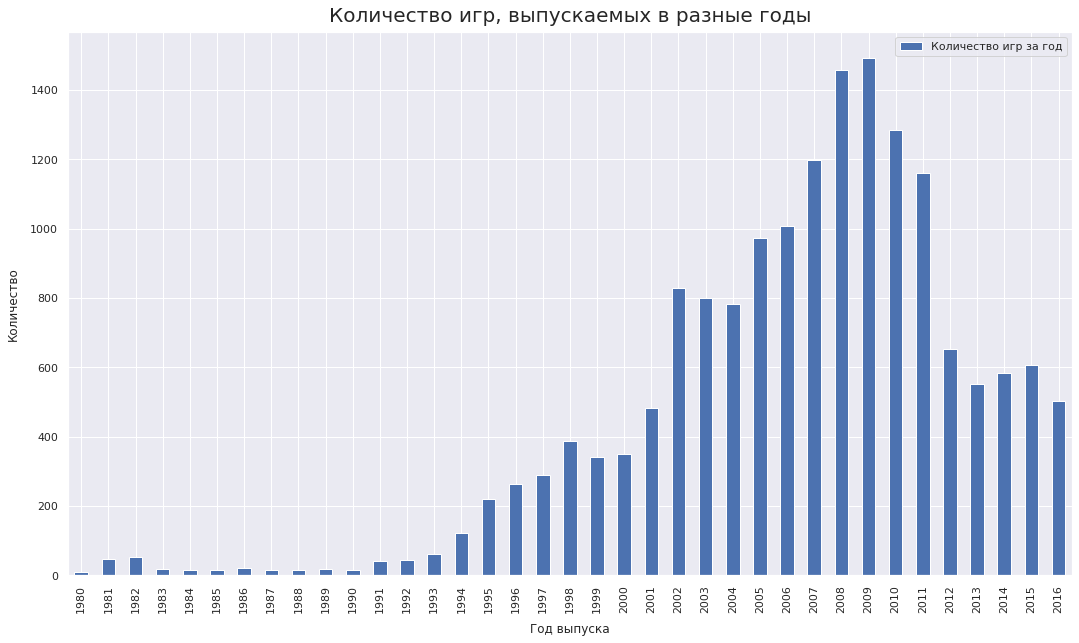

In [30]:
data.pivot_table(index='year_of_release', 
                 values='name', 
                 aggfunc='count').reset_index().plot(x='year_of_release', kind='bar', figsize=(18, 10), color='b')
plt.xlabel('Год выпуска', labelpad=10)
plt.ylabel('Количество', labelpad=10)
plt.legend(['Количество игр за год'])
plt.title('Количество игр, выпускаемых в разные годы', fontdict= {'fontsize': 20}, pad = 10);

### Вывод:

Более равномерно по количеству игры выпускались в период с 2012 по 2016, именно этот период будем использовать как актуальный для построения прогноза. Бум игровой индустрии (2005 - 2011) рассматривать не будем при прогнозе.

### 3.2 Как менялись продажи по платформам за каждый период?

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

In [31]:
# Добавим в нашу таблицу столбец с сумарными продажами для каждой игры
data['total'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Чтобы было не скучно смотреть на таблицы, сделаем "тепловую карту" данных.

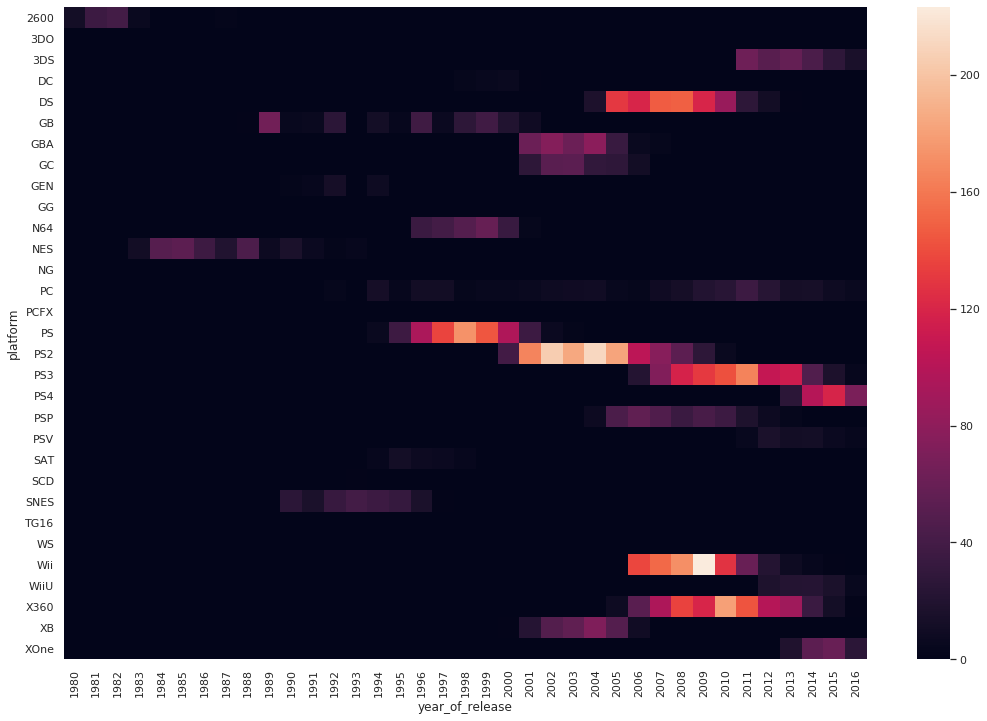

In [32]:
plt.figure(figsize=(18, 12))
sns.heatmap(data.pivot_table(index='platform', 
                             values='total', 
                             columns='year_of_release', aggfunc='sum').fillna(0));

Ответим на вопрос - ___За какой характерный срок появляются новые и исчезают старые платформы?___

### Вывод:

Взглянув на тепловой график можно визуально оценить, что платформа приносит прибыль в течении 7 - 10 лет. Появляются новые платформы (как продолжение линейки одного производителя) за 3-4 года до окончания поддержки предыдущей версии и "живут" 7 - 10 лет.

### 3.3 Выделим данные за актуальный период

Для построения прогноза на следующий год (2017) целесообразно выбрать данные за последние 5 лет (2012 - 2016) годы исходя из количества игр, выпускаемых в разные годы. Сделаем срез данных для дальнейшего анализа:

In [33]:
data_actual = data[data['year_of_release'] >= 2012].copy()

In [34]:
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2895 entries, 16 to 16714
Data columns (total 12 columns):
name               2895 non-null object
platform           2895 non-null object
year_of_release    2895 non-null int64
genre              2895 non-null object
na_sales           2895 non-null float64
eu_sales           2895 non-null float64
jp_sales           2895 non-null float64
other_sales        2895 non-null float64
critic_score       1315 non-null float64
user_score         1535 non-null float64
rating             1770 non-null object
total              2895 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 294.0+ KB


В дальнейшей работе не будут учитываться данные за предыдущие годы.

### 3.4 Какие платформы лидируют по продажам, растут или падают?

Определим платформы, которые лидируют по продажам, рассчитав суммарное значения продаж для каждой:

In [35]:
top_total = data_actual.pivot_table(index='platform', values='total', aggfunc='sum').sort_values(by='total', ascending=False).head(5)

# Выведем 5 платформ, лидирующих по количеству продаж на 2016 год.
top_total

,total
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,195.80
XOne,159.32


Определим функцию для отрисовки столбиковых диаграмм:

In [36]:
def bar_func(first, second, title, figsize=(14, 8), color='y'):
    # определим размер графиков для столбиковых диаграмм
    plt.figure(figsize=figsize)
    plt.title(title, pad=10, fontsize = 20)
    plt.bar(first, second, color=color);

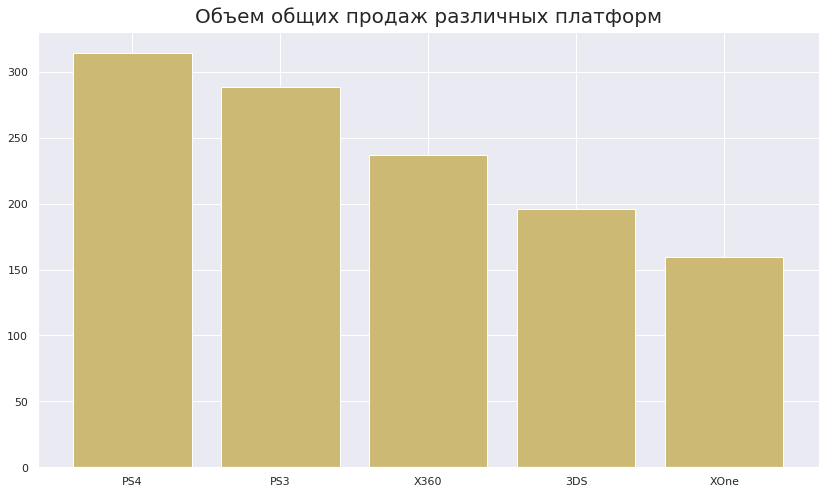

In [37]:
# покажем на графике данные из таблицы top_total
bar_func(top_total.reset_index()['platform'], top_total.reset_index()['total'], 'Объем общих продаж различных платформ');

Чтобы понять, растут продажи или падают, рассчитаем средние значения продаж за последние 2 года и сравним их:

In [38]:
x = data_actual.pivot_table(index='year_of_release', columns='platform', values='total', aggfunc='sum')
x

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,57.76,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,12.16,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


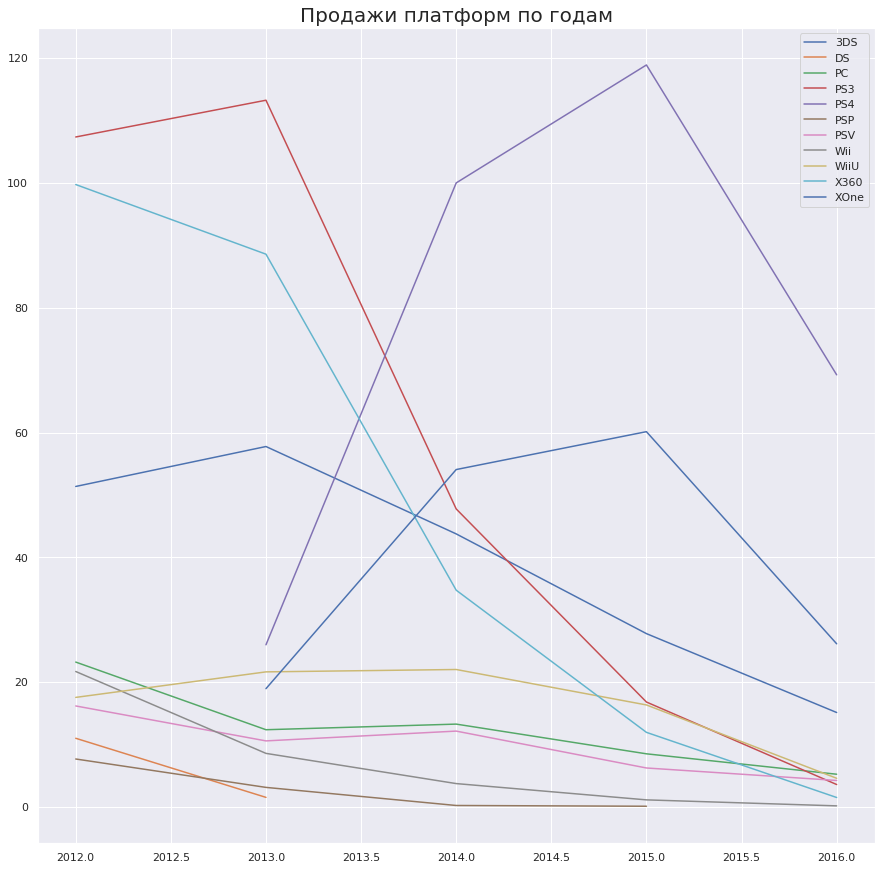

In [39]:
fig, ax = plt.subplots(figsize=(15,15)) # будем все графики рисовать в на одном рисунке, размер зададим

lines = []   # список для хранения объектов графиков

for i in x.columns:
    lines += ax.plot(x[i])

# Задаем линии, метки легенды и заголовок
ax.title.set_text('Продажи платформ по годам')
ax.title.set_size(20)
ax.legend(lines, x.columns, loc='upper right');

### Выводы:

1. Исходя из полученных графиков, продажи на 2016 год _падают_ у всех платформ, но у всех, кроме PS4 и XOne продажи падают равномерно в течение нескольких лет.
2. У PS4 и XOne был _резкий рост_ продаж с 2013 года (старт продаж платформ), но в период 2015 - 2016 годов продажи снизились.
3. Можно выделить 3 потенциально прибыльные платформы: PS4, XOne, 3Ds.

### 3.5 Велика ли разница в глобальных продажах? А в средних продажах на разных платформах?

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.

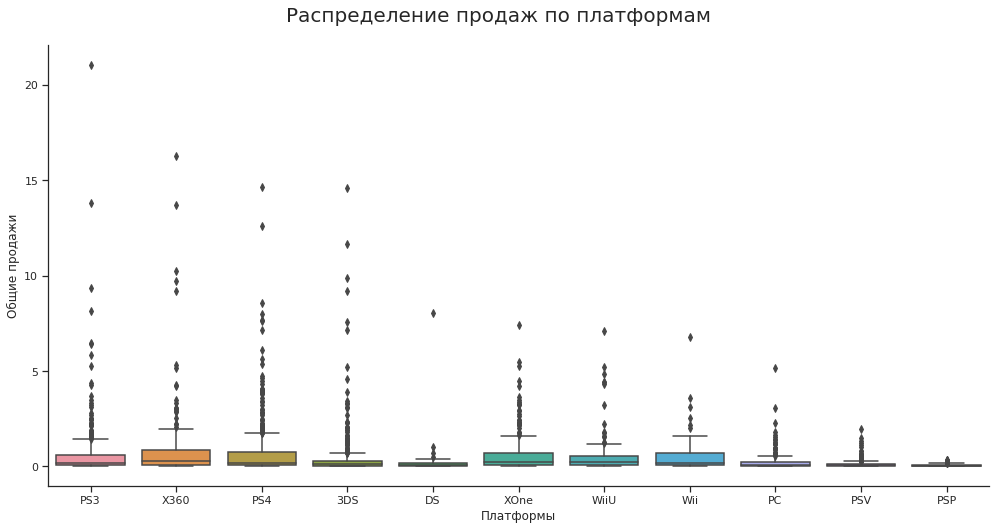

In [40]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('platform', 'total', data=data_actual, kind='box', height=7, aspect=2)
    g.set_axis_labels('Платформы', 'Общие продажи')
    g.fig.suptitle('Распределение продаж по платформам', size=20, y=1.05);

Уберем пиковые значения. Основные объемы продаж лежат на уровне менее 3:

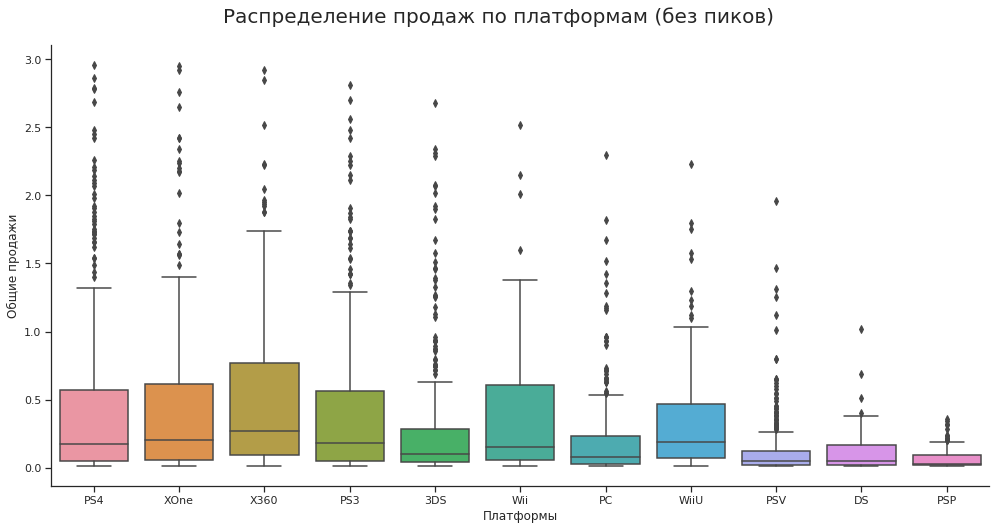

In [41]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('platform', 'total', data=data_actual[data_actual['total'] < 3], kind='box', height=7, aspect=2)
    g.set_axis_labels('Платформы', 'Общие продажи')
    g.fig.suptitle('Распределение продаж по платформам (без пиков)', size=20, y=1.05);

### Вывод:

В глобальных продажах разница велика только по сравнению с портативными платформами(PSV, PSP, DS, 3DS). Домашние системы (стационарные) по продажам в основном не сильно различаются, имеют характерные пики, связаные с эксклюзивным контентом для платформы.

Отдельно можно сказать, что PC теряет свою популярность по сравнению с более современными платформами (на них лучше оптимизация и больше эксклюзивов).

__Средние продажи__

Добавим в таблицу данные по средним продажам для каждой игры:


In [42]:
data_actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,82.0,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,81.0,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,53.0,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [43]:
data_actual['mean_sales'] = (data_actual['na_sales'] + 
                             data_actual['eu_sales'] + 
                             data_actual['jp_sales'] + 
                             data_actual['other_sales']) / 4

Построим распределения в виде ящика с усами:

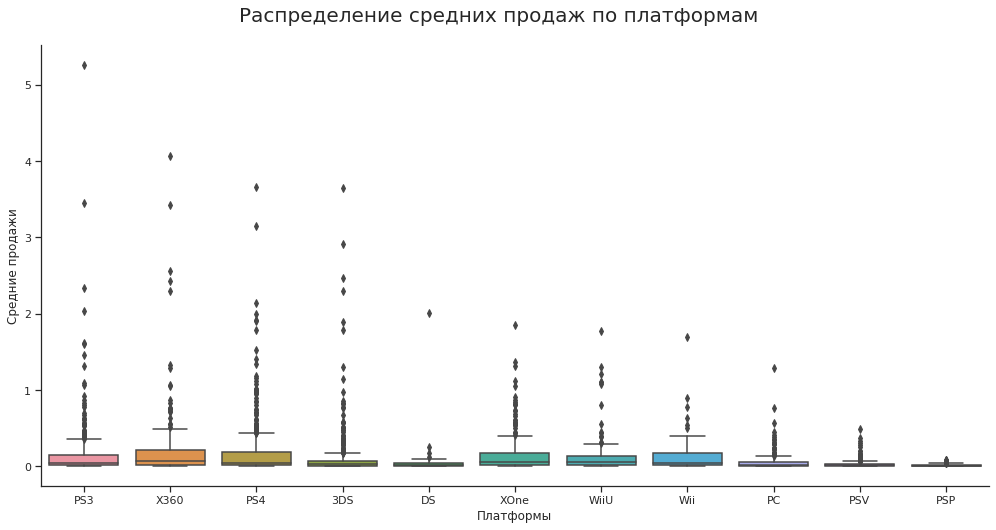

In [44]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('platform', 'mean_sales', data=data_actual, kind='box', height=7, aspect=2)
    g.set_axis_labels('Платформы', 'Средние продажи')
    g.fig.suptitle('Распределение средних продаж по платформам', size=20, y=1.05);

Уберем пиковые значения. Основные объемы продаж лежат на уровне менее 1:

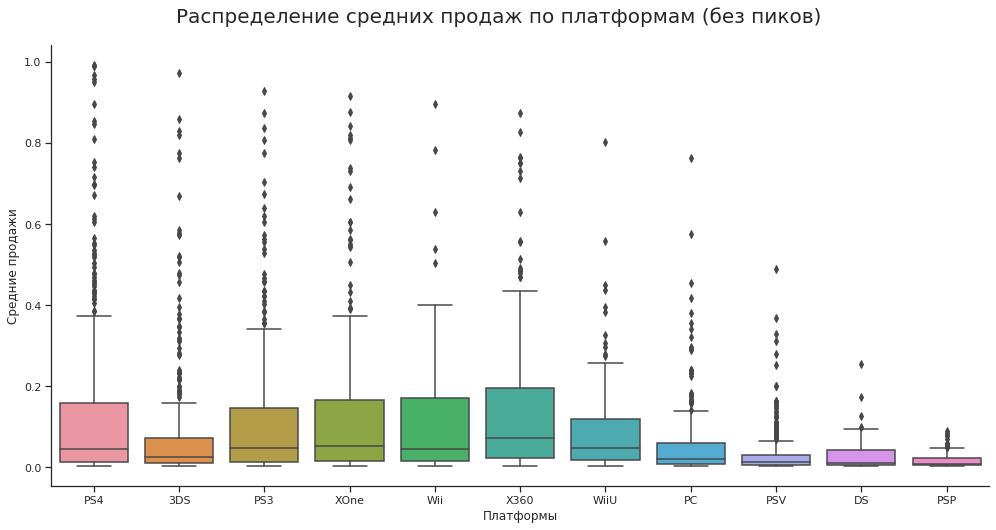

In [45]:
with sns.axes_style(style='ticks'):
    g = sns.catplot('platform', 'mean_sales', data=data_actual[data_actual['mean_sales'] < 1], kind='box', height=7, aspect=2)
    g.set_axis_labels('Платформы', 'Средние продажи')
    g.fig.suptitle('Распределение средних продаж по платформам (без пиков)', size=20, y=1.05);

### Вывод:

По большому счету, средние и глобальные продажи не различаются на разных платформах (распределения очень похожи на полученные для глобальных продаж).

### 3.6  Оценка влияния на продажи внутри одной популярной платформы отзывов пользователей и критиков

Выберем одну из популярных платформ, например, XOne

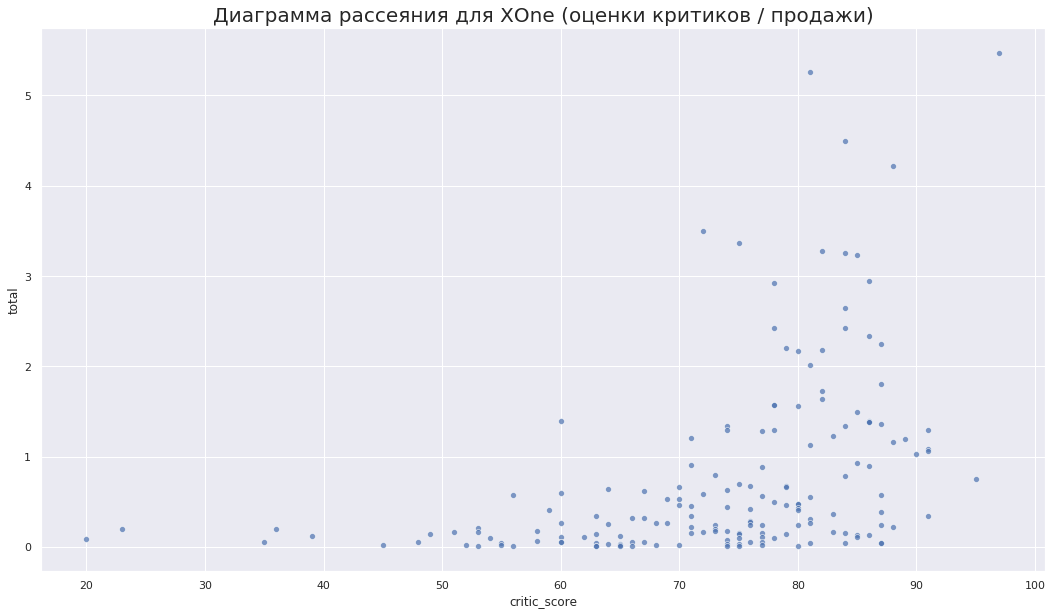

In [46]:
# определим функцию для отрисовки диаграммы рассеяния
def scatter_func(x, y, data, title='NO TITLE'):
    plt.figure(figsize=(18, 10))
    ax = sns.scatterplot(x=x, y=y, data=data, alpha=0.7)
    ax.set_title(title, size=20)

# получим диаграмму рассеяния для оценок критиков
scatter_func('critic_score', 
             'total', 
             data_actual[data_actual['platform'] == 'XOne'], 
             'Диаграмма рассеяния для XOne (оценки критиков / продажи)')

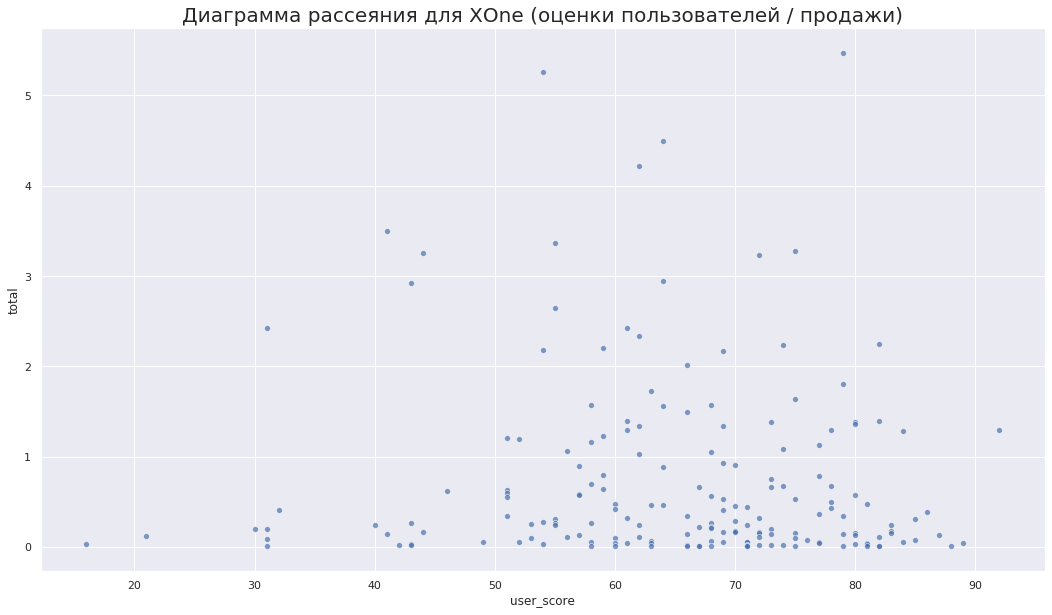

In [47]:
# получим диаграмму рассеяния для оценок пользователей
scatter_func('user_score', 
             'total', 
             data_actual[data_actual['platform'] == 'XOne'], 
             'Диаграмма рассеяния для XOne (оценки пользователей / продажи)')

In [48]:
data_actual[data_actual['platform'] == 'XOne'][['total', 'critic_score', 'user_score']].corr()

,total,critic_score,user_score
total,1.00,0.42,-0.07
critic_score,0.42,1.00,0.47
user_score,-0.07,0.47,1.00


### Выводы:


1. Исходя из полученной матрицы корреляции и диаграмм рассеяния, общие продажи игр имеют положительную корреляцию с оценками критиков.
2. Объемы продаж не зависят от оценок пользователей.
3. Оценки пользователей зависят от оценок критиков. Видимо, пользователи решают покупать после отзывов критиков, так как у критиков в основном есть ранний доступ к оценеваемой игре.

Проверим, верны ли выводы в целом для остальных платформ:

In [49]:
data_actual[data_actual['platform'] != 'XOne'][['total', 'critic_score', 'user_score']].corr()

,total,critic_score,user_score
total,1.00,0.30,0.01
critic_score,0.30,1.00,0.53
user_score,0.01,0.53,1.00


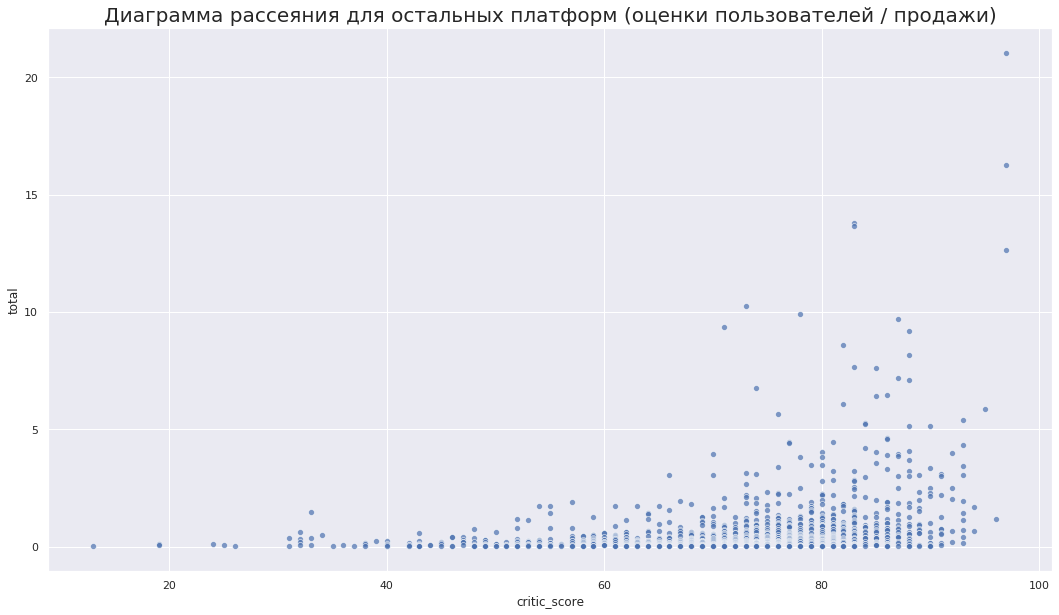

In [50]:
# получим диаграмму рассеяния для оценок критиков
scatter_func('critic_score', 
             'total', 
             data_actual[data_actual['platform'] != 'XOne'], 
             'Диаграмма рассеяния для остальных платформ (оценки пользователей / продажи)')

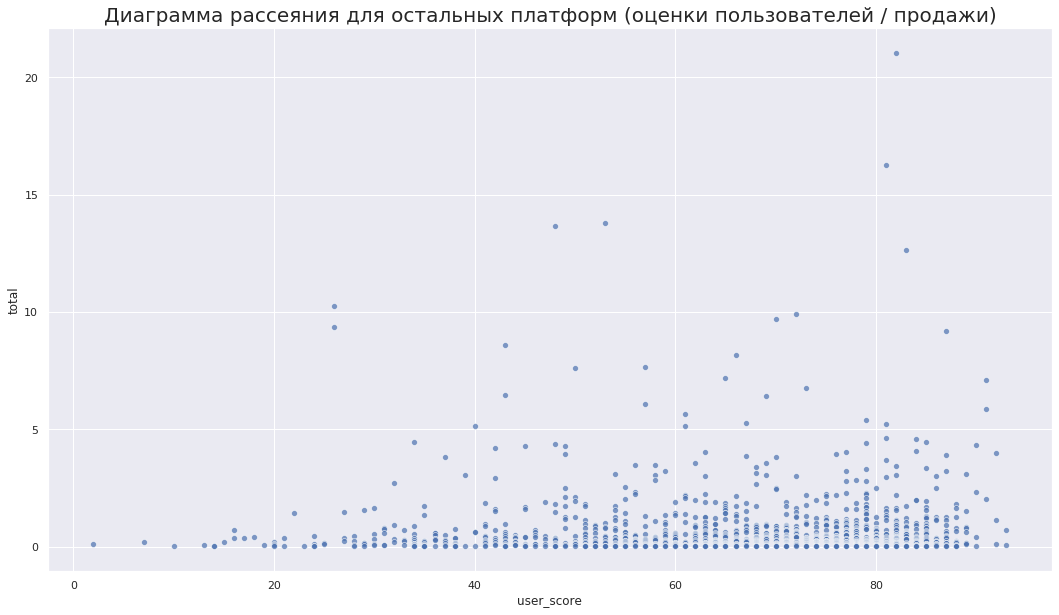

In [51]:
# получим диаграмму рассеяния для оценок пользователей
scatter_func('user_score', 
             'total', 
             data_actual[data_actual['platform'] != 'XOne'], 
             'Диаграмма рассеяния для остальных платформ (оценки пользователей / продажи)')

### Вывод:

Выводы, сделанные для одной популярной платформы в целом верны для всех остальных.

### 3.7 Распределение игр по жанрам

Построим столбиковую диаграмму распределения игр по жанрам от общих прадаж.

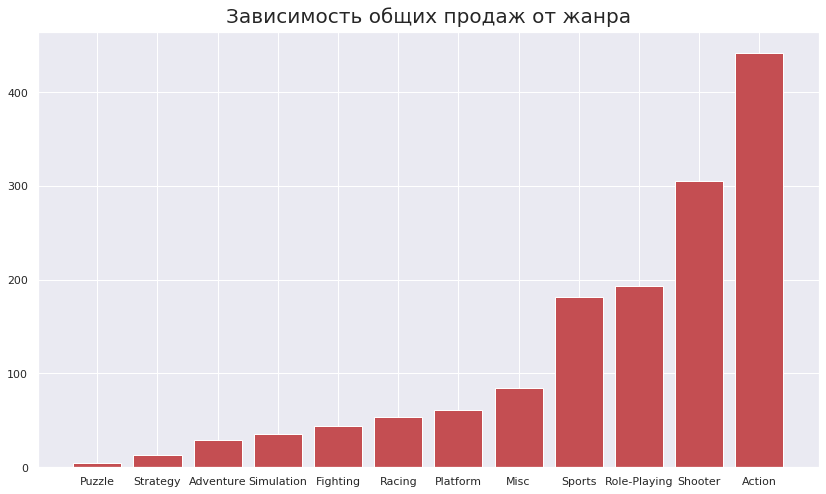

In [52]:
# сгенерим сводную таблицу, которую отобразим на диаграмме
genre_total = data_actual.pivot_table(index='genre', values='total', aggfunc='sum').sort_values(by='total').reset_index()
bar_func(genre_total['genre'], genre_total['total'], 'Зависимость общих продаж от жанра', color='r')

Можно также взглянуть на цифры по долям каждого жанра в общем на всех платформах:

In [53]:
genre_total['percent'] = (genre_total['total'] / genre_total['total'].sum()) * 100
genre_total[['genre','percent']]

,genre,percent
0,Puzzle,0.34
1,Strategy,0.92
2,Adventure,2.04
3,Simulation,2.46
4,Fighting,3.07
5,Racing,3.70
6,Platform,4.21
7,Misc,5.87
8,Sports,12.51
9,Role-Playing,13.34


### Выводы:


1. Самые продаваемые игры - игры жанров Action, Shooter, Role-Playing, Sports, Misc. На их долю приходится 77 % рынка.
2. На фоне всех жанров сильно выделяются первые 4 лидера по продажам - продажи в этих жанрах превышают в 2 и более раза продажи других жанров.
3. Жанр с самыми низкими продажами - Puzzle, также продаж меньше более чем в 2 раза по сравнению с соседним жанром Strategy (доля продаж - 0,34 %).

## 4 Составление портрета пользователя каждого региона

### 4.1 Самые популярные платформы (топ-5). Описание различия в долях продаж.

Самые популярные платформы определим по суммарным продажам игр на все платформы:

In [54]:
pop_platform = data_actual.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
pop_platform

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.85,87.84,56.15
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.41,21.11,11.09
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


Заменим значения в столбцах на доли продаж:

In [55]:
for i in pop_platform.columns:
    pop_platform[i] = (pop_platform[i] / pop_platform[i].sum()) * 100

In [56]:
pop_platform

,eu_sales,jp_sales,na_sales
platform,,,
3DS,8.45,45.58,9.49
DS,0.70,1.93,0.78
PC,7.45,0.00,3.23
PS3,21.07,18.31,17.47
PS4,27.82,8.28,18.37
PSP,0.08,5.43,0.02
PSV,2.25,10.95,1.87
Wii,2.35,1.76,2.95
WiiU,4.96,6.75,6.44


Определим топ 5 популярных платформ по регионам. Над каждым столбиком платформы будет указана доля продаж в регионе:

In [57]:
# определим словарь с заголовками графиков
dict_sales = {'eu_sales': 'Топ-5 продаж в Европе', 
              'jp_sales': 'Топ-5 продаж в Японии',
              'na_sales': 'Топ-5 продаж в Северной Америке'}

# напишем функцию, которая будет строить графики
def print_top_5(pivot, dict_top):
    with sns.axes_style(style='white'):    # построим графики без серого фона
        # построим графики для всех регионов
        for i in pivot.columns:

            fig, ax = plt.subplots(figsize=(12, 8))   # зададим нужны размер
            ax_bar = ax.bar(pivot.nlargest(5, i)[i].index, height=pivot.nlargest(5, i)[i], color='sandybrown') # нарисуем столбики

            # сделаем надписи над столбиками
            for bar in ax_bar:
                height = bar.get_height().round(2)
                ax.annotate('{}%'.format(height),
                            xy=(bar.get_x() + bar.get_width() / 2, height), # зададим расположение цифр с процентами
                            xytext=(0, 3),  # зададим отступ
                            textcoords="offset points",
                            ha='center', va='bottom')
            ax.set_title(dict_top[i], size=18)  # добавим заголовок
            ax.set_ylabel('Доля продаж')   # подпишем ось y
            plt.show()

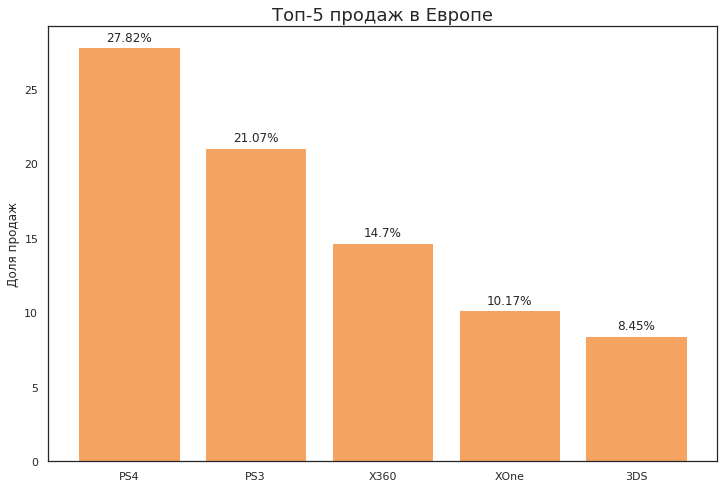

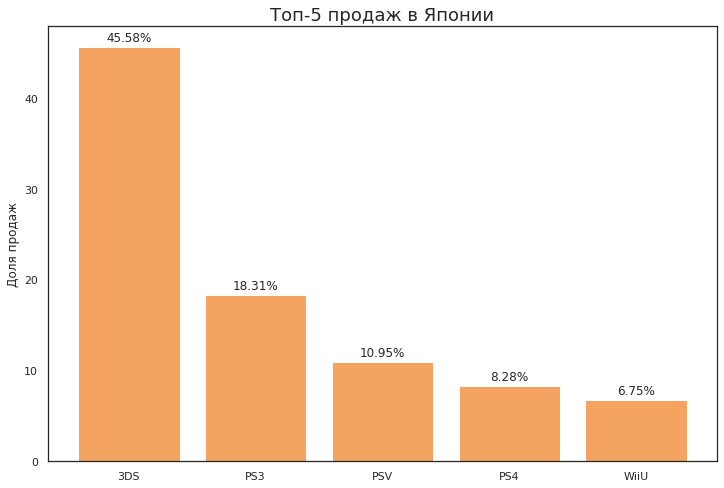

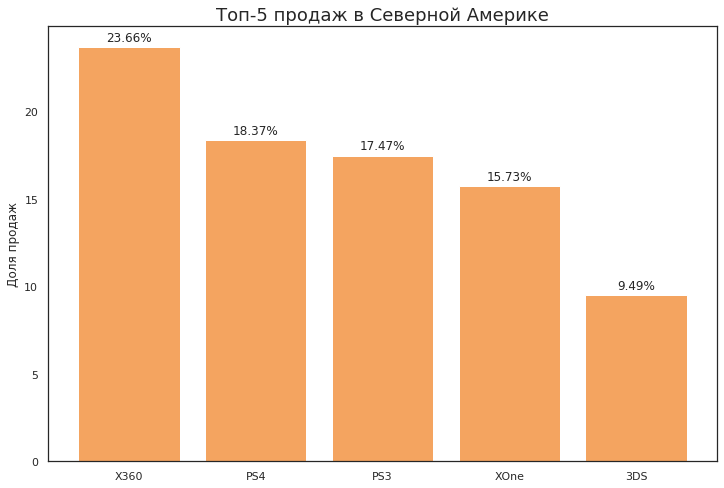

In [58]:
# Вызовем функцию, передав ей сводную таблицу и словарь с заголовками
print_top_5(pop_platform, dict_sales)

### Выводы:

1. В разных регионах на первых местах топа находятся разные платформы.
2. Определены топы-5 платформ для каждого региона, а именно:
  - В Европе пользуются популярностью PS4, PS3, X360, XOne, 3DS;
  - В Японии - 3DS, PS3, PSV, PS4, WiiU;
  - В Северной Америке - X360, PS4, PS3, XOne, 3DS.
3. Различия в долях продаж можно выделить для платформ, входящие в топы всех регионов - PS4 и PS3:
  - самая большая доля продаж игр для PS4 и PS3 на Европейском рынке (27,82 % и 21,07 % (соответственно) от всех продаж);
  - самая малая доля продаж игр для PS4 в Японии, а для PS3 в Северной Америке.
4. Что типично, в Японии более популярны Японские платформы (3DS и линейка PS), в Северной Америке популярны американские (Xbox), а в Европе и те и другие.

### 4.2 Самые популярные жанры (топ-5). Пояснение разницы.

In [59]:
pop_genre = data_actual.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
pop_genre

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.53,52.80,178.02
Adventure,9.46,8.24,9.00
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.30
Role-Playing,48.58,65.54,64.11
Shooter,113.49,9.23,144.81


Заменим значения в столбцах на доли продаж:

In [60]:
for i in pop_genre.columns:
    pop_genre[i] = (pop_genre[i] / pop_genre[i].sum()) * 100

In [61]:
pop_genre

,eu_sales,jp_sales,na_sales
genre,,,
Action,31.46,27.40,30.08
Adventure,1.87,4.28,1.52
Fighting,2.13,4.90,3.34
Misc,5.19,6.67,6.45
Platform,4.22,4.48,4.29
Puzzle,0.28,1.11,0.19
Racing,5.38,1.30,2.92
Role-Playing,9.58,34.01,10.83
Shooter,22.38,4.79,24.46


Определим топ 5 популярных жанров по регионам. Над каждым столбиком жанра будет указана доля продаж в регионе:

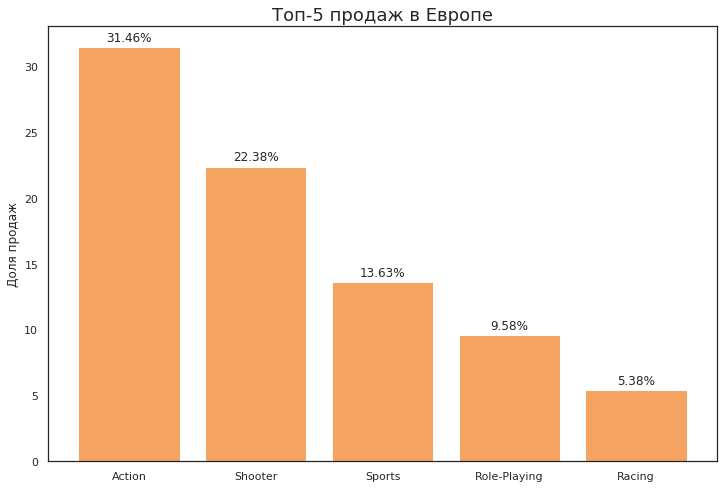

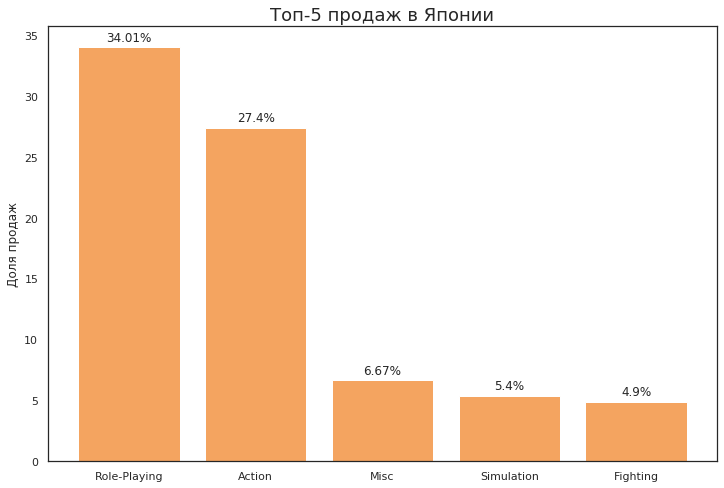

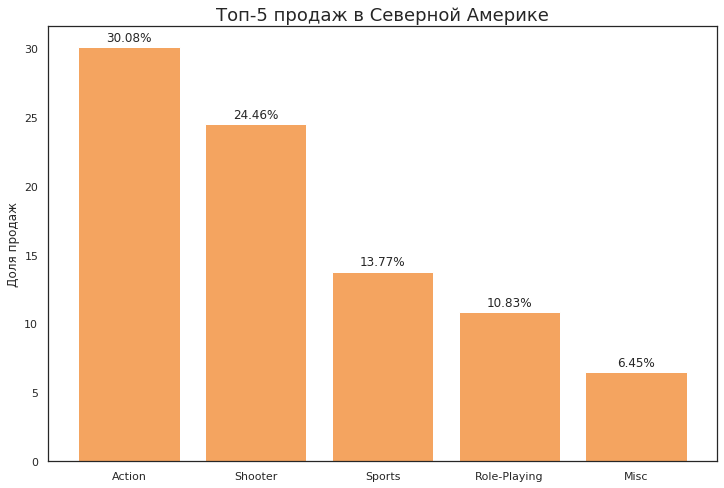

In [62]:
# Вызовем функцию, передав ей сводную таблицу и словарь с заголовками
print_top_5(pop_genre, dict_sales)

### Выводы:

1. Как видно, популярные жанры в Европе и Северной Америке практически не различаются, в то время, как в Японии своя атмосфера в плане жанров)).
2. Определены топы-5 жанров для каждого региона, а именно:
  - В Европе самые популярные жанры - Action, Shooter, Sports, Role-Playing, Racing;
  - В Японии - Role-Playing, Action, Misc, Simulation, Fighting;
  - В Северной Америке - Action, Shooter, Sports, Role-Playing, Misc.
3. Есть один общий жанр для всех регионов, попавший в топ-5 - жанр Action. Самая большая доля рынка в Европе(31,46%), но по регионам не сильно различается.
4. Первая четверка жанров в Европе и Северной Америке практически не отличается в долях рынка.

### 4.3 Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

In [63]:
data_actual['rating'].unique()

array(['M', nan, 'E', 'E10+', 'T'], dtype=object)

Для наших данных имеем рейтинги:
- 'M' - для взрослых (старше 17 лет);
- 'E' - для всех;
- 'E10+' - для всех от 10 лет и старше;
- 'T' - для подростков (для всех от 13 лет и старше).

Определим функцию, которая будет строить графики для разных регионов. Сделаем ящики с усами.

In [64]:
# определим словарь с заголовками графиков
dict_sales = {'eu_sales': 'Влияние рейтинга ESRB на продажи в Европе', 
              'jp_sales': 'Влияние рейтинга ESRB на продажи в Японии',
              'na_sales': 'Влияние рейтинга ESRB на продажи в Америке'}

def esbr_effect(data, reg_sales):
    with sns.axes_style(style='ticks'):
        g = sns.catplot('rating', reg_sales, data=data, kind='box', height=10, aspect=1.2)
        g.set_axis_labels('Рейтинг', 'Уровень продаж')
        g.fig.suptitle(dict_sales[reg_sales], size=20, y=1.05);

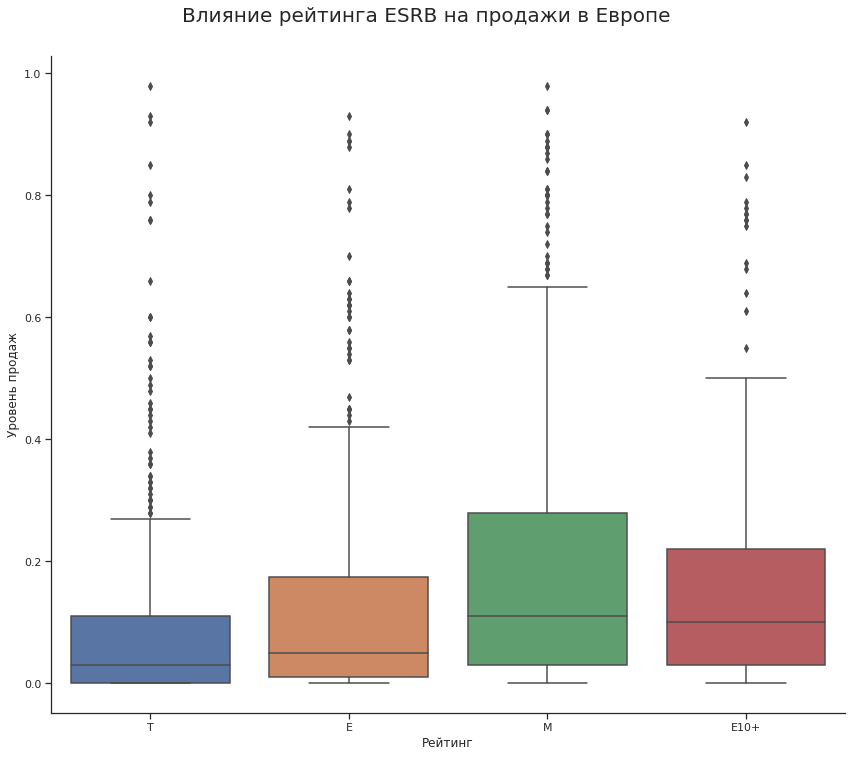

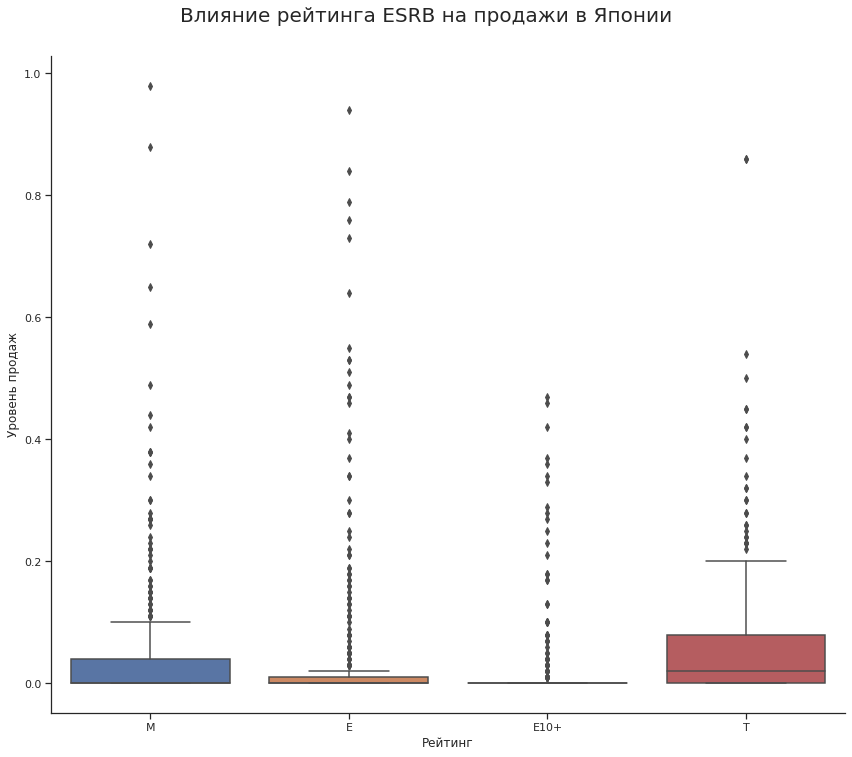

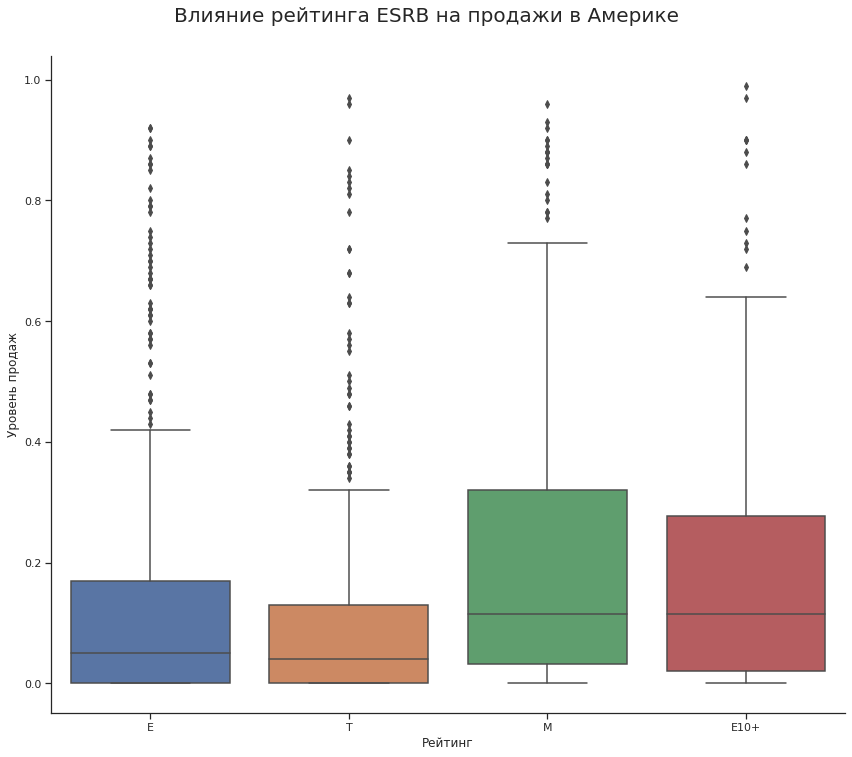

In [65]:
# вызовем нашу функцию для всех регионов и посмотрим на распределения
for i in ('eu_sales', 'jp_sales', 'na_sales'):
    esbr_effect(data_actual[data_actual[i] < 1], i) # выбираем условие < 1 чтобы избавиться от длинных хвостов

### Выводы:

1. В Европе и Северной Америке игры с рейтингом "для подростков" продаются хуже всего, хотя в Японии медианные значения продаж самые высокие.
2. Самые прибыльные игры в Европе и Северной Америке - с рейтингом 'для взрослых'.
3. Игры с рейтингом "Е10+" также очень прибыльны в Европе и Северной Америке, но в Японии практически не приносят прибыли. Возможно, их в Японии просто не продают, или завышают рейтинг.
4. Рейтинг игр влияет на продажи в каждом регионе, лучше покупают игры с рейтингом для взрослых в Европе и Америке, с рейтингом для подростков - в Японии. Это определяет возрастную категорию в разных странах - в Японии более молодые игроки.

## 5 Проверка гипотез

### 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую гипотезу - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC различны.

Для проверки гипотезы используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

Посмотрим на плотности распределения пользовательских рейтингов для этих платформ:

In [66]:
# сохраним в отдельных переменных пользовательские оценки отдельно для XOne и PC, удалив nan значения
x_one_score = data_actual[data_actual['platform'] == 'XOne']['user_score'].dropna()
pc_score = data_actual[data_actual['platform'] == 'PC']['user_score'].dropna()

In [67]:
# определим функцию для отрисовки плотности распределения оценок пользователей
def fig_kde(first, second, first_label, second_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(first, kde_kws={"shade": True}, hist=False, ax=ax, label=first_label)
    sns.distplot(second, kde_kws={"shade": True}, hist=False, ax=ax, label=second_label)
    ax.set_ylabel('Частота')
    ax.set_xlabel('Оценка')
    ax.set_title('Графики распределения плотностей пользовательских оценок для {} и {}'.format(first_label, second_label), 
                 size=16, 
                 pad=10)
    ax.legend(loc='upper left');

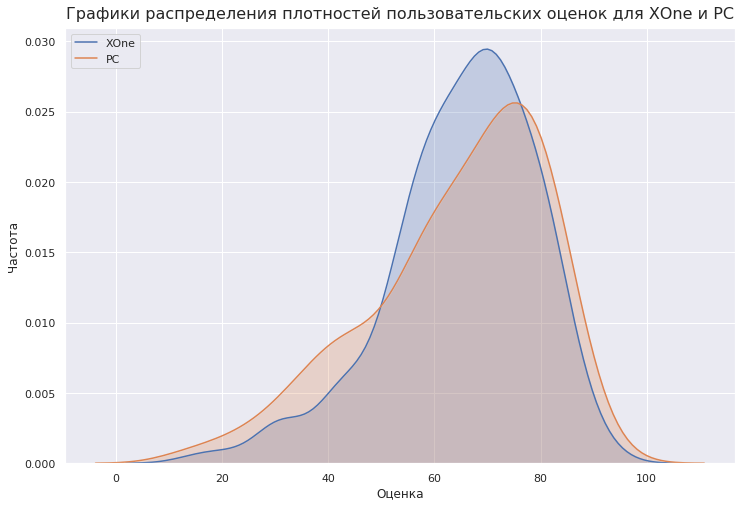

In [68]:
# вызовем функцию для обоих платформ
fig_kde(x_one_score, pc_score, 'XOne', 'PC')

Оба графика сильно пересекаются, распределение оценок для XOne более равномерное. Предварительно по площади пересечения двух распределений можно предположить, что не получится отвергнуть нулевую гипотезу. Проверим нулевую гипотезу при уровне значимости равном 5 %.

In [69]:
alpha = 0.05
result = st.ttest_ind(x_one_score, pc_score)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643805
Не получилось отвергнуть нулевую гипотезу


__Вывод__: Средние пользовательские рейтинги игр платформ Xbox One и PC в целом не сильно отличаются. Предположу, что так как это игры для платформ Microsoft, то и оптимизация для них должна быть примерно на одинаковом уровне.

### 5.2 Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

Сформулируем нулевую гипотезу - средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») равны.

Альтернативная гипотеза - средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») различны.

Как и в 5.1 используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

In [70]:
# сохраним данные пользовательских оценок для обоих жанров в соответствующие переменные, которые используем для проверки гипотез
action_score = data_actual[data_actual['genre'] == 'Action']['user_score'].dropna()
sports_score = data_actual[data_actual['genre'] == 'Sports']['user_score'].dropna()

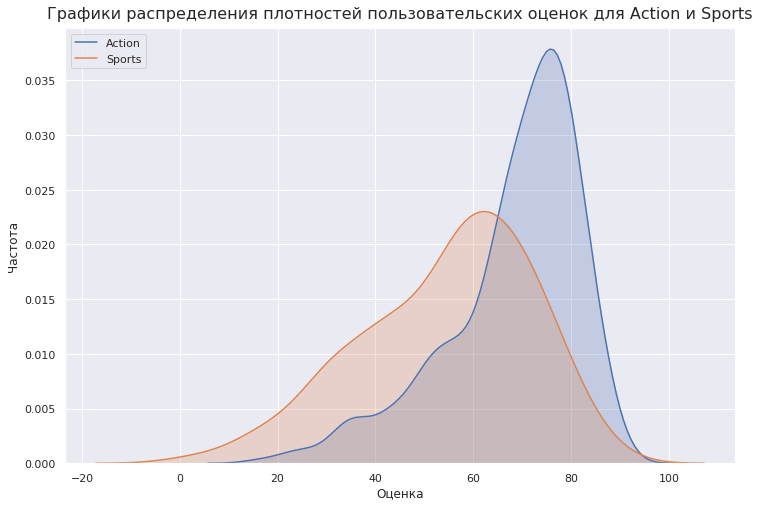

In [71]:
# вызовем функцию для обоих платформ
fig_kde(action_score, sports_score, 'Action', 'Sports')

На этом графике распределения пользовательских оценок также сильно пересекаются, но распределение оценок для жанра спорт имеет меньшую частоту распределения оценок. Проверим гипотезу при alpha = 0.05:

In [72]:
alpha = 0.05
result = st.ttest_ind(action_score, sports_score)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.5171027713334784e-26
Отвергаем нулевую гипотезу


__Вывод__: средние пользовательские оценки для жанров Action и Sports действительно различны. Если проанализировать графики, в основном оценки для Action расположены в диапазоне от 40 до 95, а оценки для Sport - в пределах от 20 до 80.

## Общие выводы:

В этом проекте были исследованы данные для планирования рекламной компании на 2017 год.

В исходных данных были исследованы пропуски и заменены, там, где это было необходимо или возможно, на ненулевые значения.
Данные в некоторых столбцах были приведены к правильному типу.



На основе полученных после подготовки данных были сделаны следующие выводы:
- выбран актуальный период - с 2012 по 2016 г., данные за предыдущий период не учитывались;
- новые платформы (как продолжение линейки одного производителя) появляются за 3-4 года до окончания поддержки предыдущей версии и пользуются спросом 7 - 10 лет;
- выделены 3 потенциально прибыльных платформы - PS4, XOne, 3Ds;
- в глобальных продажах разница велика только по сравнению с портативными платформами(PSV, PSP, DS, 3DS). Домашние системы (стационарные) по продажам в основном не сильно различаются, имеют характерные пики, связаные с эксклюзивным контентом для платформы;
- средние и глобальные продажи не различаются для платформ;
- общие продажи игр имеют положительную корреляцию с оценками критиков (30 %), в то время, как оценки пользователей не коррелируют с общими продажами;
- оценки пользователей зависят от оценок критиков (53 %);
- cамые продаваемые игры - игры жанров Action, Shooter, Role-Playing, Sports, Misc. На их долю приходится 77 % рынка;
- выделены топы-5 платформ и жанров для различных регионов в части продаж;
- Различия в долях продаж можно выделить для платформ, входящие в топы всех регионов - PS4 и PS3:
  - самая большая доля продаж игр для PS4 и PS3 на Европейском рынке (27,82 % и 21,07 % (соответственно) от всех продаж);
  - самая малая доля продаж игр для PS4 в Японии, а для PS3 в Северной Америке.
- выделен общий жанр для всех регионов, попавший в топ-5 - жанр Action. Самая большая доля рынка в Европе(31,46%), но по регионам не сильно различается;
- в Европе и Северной Америке игры с рейтингом "для подростков" продаются хуже всего, хотя в Японии медианные значения продаж самые высокие.
- самые прибыльные игры в Европе и Северной Америке - с рейтингом 'для взрослых'
- игры с рейтингом "Е10+" также очень прибыльны в Европе и Северной Америке, но в Японии практически не приносят прибыли.

Также были сформулированы и проверены гипотезы относительно пользовательских оценок, выполнены их проверки и получены следующие результаты:
1. Средние пользовательские рейтинги игр платформ Xbox One и PC в целом не сильно отличаются.
2. Cредние пользовательские оценки для жанров Action и Sports различны, причем игры жанра Action получают в среднем более высокие оценки пользователей.